In [2]:
import liblzfse
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt
import open3d as o3d
from quaternion import quaternion, as_rotation_matrix
from PIL import Image
import json
import tqdm
from torch.utils.data import Dataset
from typing import List
import os
import pickle as pkl
import json
import shutil
import zipfile

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def load_image(filepath):
    return np.asarray(Image.open(filepath))

def load_depth(filepath):
    with open(filepath, 'rb') as depth_fh:
        raw_bytes = depth_fh.read()
        decompressed_bytes = liblzfse.decompress(raw_bytes)
        depth_img = np.frombuffer(decompressed_bytes, dtype=np.float32)

    # depth_img = depth_img.reshape((960, 720))  # For a FaceID camera 3D Video
    depth_img = depth_img.reshape((256, 192))  # For a LiDAR 3D Video

    return depth_img

def load_conf(filepath):
    with open(filepath, 'rb') as depth_fh:
        raw_bytes = depth_fh.read()
        decompressed_bytes = liblzfse.decompress(raw_bytes)
        depth_img = np.frombuffer(decompressed_bytes, dtype=np.uint8)
    return depth_img

In [4]:
class R3DSemanticDataset(Dataset):
    def __init__(self, path: str, custom_classes: List[str] = None):
        self._path = path
        
        self._reshaped_depth = []
        self._reshaped_conf = []
        self._depth_images = []
        self._rgb_images = []
        self._confidences = []

        self._metadata = self._read_metadata(path, custom_classes)
        self.global_xyzs = []
        self.global_pcds = []
        self._load_data()
        self._reshape_all_depth_and_conf()
        self.calculate_all_global_xyzs()

    def _read_metadata(self, path, custom_classes):
        with open(f"{path}/metadata", "r") as f:
            metadata_dict = json.load(f)
            
        # Now figure out the details from the metadata dict.
        self.rgb_width = metadata_dict["w"]
        self.rgb_height = metadata_dict["h"]
        self.image_size = (self.rgb_width, self.rgb_height)
        
        self.poses = np.array(metadata_dict["poses"])
        self.camera_matrix = np.array(metadata_dict["K"]).reshape(3,3).T
        
        self.fps = metadata_dict["fps"]
        
        self.total_images = len(self.poses)
        self.init_pose = np.array(metadata_dict["initPose"])
        
        self._id_to_name = {i: x for (i, x) in enumerate(custom_classes)} # There are no predefined IDs and names.

    def _load_data(self):
        assert self.fps # Make sure metadata is read correctly first.
        for i in tqdm.trange(self.total_images):
            # Read up the RGB and depth images first.
            rgb_filepath = f"{self._path}/rgbd/{i}.jpg"
            depth_filepath = f"{self._path}/rgbd/{i}.depth"
            conf_filepath = f"{self._path}/rgbd/{i}.conf"
            
            depth_img = load_depth(depth_filepath)
            rgb_img = load_image(rgb_filepath)
            confidence = load_conf(conf_filepath).reshape(256, 192)
            
            # Now, convert depth image to real world XYZ pointcloud.
            self._depth_images.append(depth_img)
            self._rgb_images.append(rgb_img)
            self._confidences.append(confidence)

    def _reshape_all_depth_and_conf(self):
        for index in tqdm.trange(len(self.poses)):
            depth_image = self._depth_images[index]
            # Upscale depth image.
            pil_img = Image.fromarray(depth_image)
            reshaped_img = pil_img.resize((self.rgb_width, self.rgb_height))
            # all_rgbs.append()
            reshaped_img = np.asarray(reshaped_img)
            self._reshaped_depth.append(reshaped_img)
            
            # Upscale confidence as well
            confidence = self._confidences[index]
            # Upscale depth image.
            conf_img = Image.fromarray(confidence)
            reshaped_conf = conf_img.resize((self.rgb_width, self.rgb_height))
            # all_rgbs.append()
            reshaped_conf = np.asarray(reshaped_conf)
            self._reshaped_conf.append(reshaped_conf)
            
    def get_global_xyz(self, index, depth_scale=1000.0, only_confident=True):
        reshaped_img = np.copy(self._reshaped_depth[index])
        # If only confident, replace not confident points with nans
        if only_confident:
            reshaped_img[self._reshaped_conf[index] != 2] = np.nan

        depth_o3d = o3d.geometry.Image(np.ascontiguousarray(depth_scale * reshaped_img).astype(np.float32))
        rgb_o3d = o3d.geometry.Image(np.ascontiguousarray(self._rgb_images[index]).astype(np.uint8))

        rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_o3d, depth_o3d, convert_rgb_to_intensity=False)
        # ratio = 2 56 / 960
        ratio = 1

        camera_intrinsics = o3d.camera.PinholeCameraIntrinsic(
            width=int(self.rgb_width * ratio), 
            height=int(self.rgb_height * ratio), 
            fx=self.camera_matrix[0, 0] * ratio,
            fy=self.camera_matrix[1, 1] * ratio,
            cx=self.camera_matrix[0, 2] * ratio,
            cy=self.camera_matrix[1, 2] * ratio
        )
        pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsics)
        # Flip the pcd
        pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

        extrinsic_matrix = np.eye(4)
        qx, qy, qz, qw, px, py, pz = self.poses[index]
        extrinsic_matrix[:3, :3] = as_rotation_matrix(quaternion(qw, qx, qy, qz))
        extrinsic_matrix[:3, -1] = [px, py, pz]
        pcd.transform(extrinsic_matrix)

        # Now transform everything by init pose.
        # self.init_pose = np.array(self.poses[5])
        init_matrix = np.eye(4)
        qx, qy, qz, qw, px, py, pz = self.init_pose
        init_matrix[:3, :3] = as_rotation_matrix(quaternion(qw, qx, qy, qz))
        init_matrix[:3, -1] = [px, py, pz]
        pcd.transform(init_matrix)

        return pcd

    def calculate_all_global_xyzs(self, only_confident=True):
        if len(self.global_xyzs):
            return self.global_xyzs, self.global_pcds
        for i in tqdm.trange(len(self.poses)):
            global_xyz_pcd = self.get_global_xyz(i, only_confident=only_confident)
            global_xyz = np.asarray(global_xyz_pcd.points)
            self.global_xyzs.append(global_xyz)
            self.global_pcds.append(global_xyz_pcd)
        return self.global_xyzs, self.global_pcds

    def __len__(self):
        return len(self.poses)

    def __getitem__(self, idx):
        result = {
            "xyz_position": self.global_xyzs[idx],
            "rgb": self._rgb_images[idx],
            "depth": self._reshaped_depth[idx],
            "conf": self._reshaped_conf[idx],
        }
        return result

In [5]:
def export(dataset,FILENAME,out_dir,start_frames = [0], offset = 5):
    step = offset
    for start in start_frames:
        count = 0
        # Open folder run{count}
        cur_dir = out_dir
        for i in range(9999):
            folder = os.path.join(cur_dir,"run{}".format(i))
            if not os.path.exists(folder):
                break
        os.mkdir(folder)
        # Open folder image_linear
        imagefolder = os.path.join(folder,"images")
        os.mkdir(imagefolder)
        # Save image in order with name "0000.jpg"
        j = 0
        for i in tqdm.tqdm(range(start,len(dataset._rgb_images),step)):
            im_arr = np.rot90(dataset._rgb_images[i],3)
            image = Image.fromarray(im_arr)
            imagename = "{:04d}.jpg".format(j)
            imagefile = os.path.join(imagefolder,imagename)
            image.save(imagefile)
            j = j+1
        # Save depth in order with name "0000.depth"
        ##############################################
        # info = {}
        # for i in range(len(dataset._reshaped_depth)):
        #     info["{:04d}.jpg".format(i)] = dataset._reshaped_depth[i].tolist()
        # depthfile = os.path.join(folder,"depth.json")
        # with open(depthfile,"w") as f:
        #     data = json.dumps(info)
        #     f.write(data)
        ##############################################
        depthfolder = os.path.join(folder,"depths")
        os.mkdir(depthfolder)
        j = 0
        for i in tqdm.tqdm(range(start,len(dataset._reshaped_depth),step)):
            path_depthfile = f"{FILENAME}/rgbd/{i}.depth"
            shutil.copy2(path_depthfile,depthfolder)
            path_new = os.path.join(depthfolder,f"{i}.depth")
            os.rename(path_new,os.path.join(depthfolder,"{:04d}.depth".format(j)))
            j = j+1
        ##############################################
        # depthfolder = os.path.join(folder,"depth_linear")
        # os.mkdir(depthfolder)
        # for i in tqdm.tqdm(range(len(dataset._reshaped_depth))):
        #     txtname = "{:04d}.pkl".format(i)
        #     txtfile = os.path.join(depthfolder,txtname)
        #     with open(txtfile,"wb") as f:
        #         pkl.dump(dataset._reshaped_depth[i],f)
        ##############################################
        # Save conf in order with name "0000.conf"
        conffolder = os.path.join(folder,"confs")
        os.mkdir(conffolder)
        j = 0
        for i in tqdm.tqdm(range(start,len(dataset._reshaped_conf),step)):
            path_conffile = f"{FILENAME}/rgbd/{i}.conf"
            shutil.copy2(path_conffile,conffolder)
            path_new = os.path.join(conffolder,f"{i}.conf")
            os.rename(path_new,os.path.join(conffolder,"{:04d}.conf".format(j)))
            j = j+1
        # Save pose in json file
        directory = {}
        j = 0
        for i in tqdm.tqdm(range(start,len(dataset.poses),step)):
            directory["{:04d}.jpg".format(j)] = dataset.poses[i].tolist()
            j = j+1
        labelfile = os.path.join(folder,"r3d_metadata.json")
        with open(labelfile,"w") as f:
            data = json.dumps(directory)
            f.write(data)
    

In [7]:
## Change the Path Here!!!
path_videofile = r"c:\Users\J.J. Bian\Desktop\FileEXPORT\videofile"
## Modify the Starting Frames Here!!!
start_frames = [1,2,3]
filelist = os.listdir(path_videofile)
for file in filelist:
    print(file)
    cur_dir = path_videofile
    if not os.path.exists(os.path.join(os.getcwd(),"All_val")):
        os.mkdir("All_val")
    out_dir = os.path.join(os.getcwd(),"All_val")
    filepath = os.path.join(file,"Shareable",file+".r3d")
    # file = filelist
    os.rename(os.path.join(cur_dir,filepath),os.path.join(cur_dir,filepath.replace("r3d","zip")))
    with zipfile.ZipFile(os.path.join(cur_dir,filepath.replace("r3d","zip")),"r") as zip_f:
        zip_f.extractall(os.path.join(cur_dir,file))
        dataset = R3DSemanticDataset(os.path.join(cur_dir,file),[])
        export(dataset,os.path.join(cur_dir,file),out_dir,start_frames=start_frames)


2022-11-01--18-45-56


100%|██████████| 27/27 [00:00<?, ?it/s]


In [7]:
# XYZ[0] = Height of the iPhone (Up + and Down -)
# XYZ[1] = Parallel to the iPhone Screen (Right + and Left -)
# XYZ[2] = Orthogonal to the iPhone Scren (Inward + and Ouward -)

Text(0.5, 0, 'Z Label')

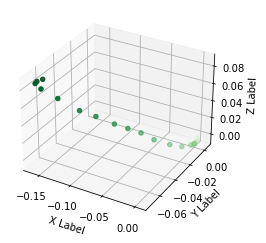

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xdata, ydata, zdata = dataset.poses[:, -3], -dataset.poses[:, -1], dataset.poses[:, -2]
ax.scatter3D(xdata[::5], ydata[::5], zdata[::5], c=range(len(zdata[::5])), cmap='Greens');
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')